## SageMaker Hosted Notebook
This notebook is hosted on a ML Optimized instance on SageMaker Platform, Some benefits include, scaling up the power of the instance and using built in Kernels(Envs) and being able to quickly connect with S3 and other AWS services using boto3 or commandline 


### Notebook Kernel 
use MXNet 1.8 Python 3.7 kernel 

# Customer Segmentation with SageMaker PCA & KMean 

In this notebook, you'll employ two, unsupervised learning algorithms to do **customer segmentation**. Customer segmentation aims to find natural groupings in population data that reveal some feature-level similarities between different CAA customers.

Using **principal component analysis** (PCA) you will reduce the dimensionality of the original customer data. Then, you'll use **k-means clustering** to assign each customer to a particular cluster based on component space. How each cluster is arranged in component space can tell you which customers are most similar and what demographic traits define that similarity; this information is most often used to inform targeted, marketing campaigns that want to appeal to a specific group of people. This cluster information is also useful for learning more about a customer by revealing patterns between factors that you otherwise may not have noticed.

### CAA Customer Data

We'll be using CAA provided ready-to-use Customer data for this workshop

### Machine Learning Workflow

To implement population segmentation, you'll go through a number of steps:
* Data loading and exploration - skip this
* Data cleaning and pre-processing - not needed since we've a cleaned dataset from CAA
* Dimensionality reduction with PCA
* Feature engineering and data transformation
* Clustering transformed data with k-means
* Extracting trained model attributes and visualizing k clusters

Each step is designed to give you practice with part of the machine learning workflow, and to demonstrate how to use SageMaker tools, such as built-in data management with S3 and built-in algorithms.

---

First, import the relevant libraries into this SageMaker notebook. 

In [2]:
# data managing and display libs
import pandas as pd
import numpy as np
import os
import io

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

In [3]:
# sagemaker libraries
import boto3
import sagemaker

### Step 1: Loading the Data from Amazon S3

This particular dataset is already in an Amazon S3 bucket; you can load the data by pointing to this bucket and getting a data file by name. 

Setup to interact with S3 using a `boto3` client.
Define the S3 bucket for your dataset

In [4]:
# boto3 client to get S3 data
s3_client = boto3.client('s3')
prefix = 'caa'
bucket_name = 'esti-sm-demo-rk'

Set the dataset file

In [5]:
# filename

# AM_Comments:
# use predfined prefix 
file_name=f'{prefix}/caa_sk_data_sample_3.0.csv'

print(file_name)

caa/caa_sk_data_sample_3.0.csv


Retrieve the data file from the bucket with a call to `client.get_object()`.

In [6]:
# get an S3 object by passing in the bucket and file name
data_object = s3_client.get_object(Bucket=bucket_name, Key=file_name)

# what info does the object contain?
#display(data_object)

This is a `bytes` datatype, which you can read it in using [io.BytesIO(file)](https://docs.python.org/3/library/io.html#binary-i-o).

In [7]:
# information is in the "Body" of the object
data_body = data_object["Body"].read()
print('Data type: ', type(data_body))

Data type:  <class 'bytes'>


In [8]:
# read in bytes data
data_stream = io.BytesIO(data_body)

# create a dataframe
customer_df = pd.read_csv(data_stream, header=0, delimiter=",") 
customer_df.head()

,customer_no,joindate,expirydate,canceldate,birthdate,gender,maxcoveragelevel,LATITUDE,LONGITUDE,APARTMENT,...,LS_Y1,LS_Y2,LS_Y3,"ERNAME_Prince Albert, SK","ERNAME_Regina--Moose Mountain, SK","ERNAME_Saskatoon--Biggar, SK","ERNAME_Swift Current--Moose Jaw, SK","ERNAME_Yorkton--Melville, SK",is_associate_yes,status_A
0,0,11/9/07,2/28/10,3/17/09,1/9/46,0,0.00,50.49179,-104.64473,0,...,0,0,0,0,1,0,0,0,0,0
1,1,11/9/07,12/31/08,6/17/16,6/20/50,0,0.00,52.16252,-106.63034,0,...,0,0,0,0,0,1,0,0,0,0
2,2,11/9/07,2/28/14,4/25/13,6/13/47,0,0.25,52.17229,-106.64965,0,...,0,0,0,0,0,1,0,0,0,0
3,3,11/9/07,12/31/09,6/17/16,10/30/51,1,0.00,53.36190,-104.01632,0,...,0,0,0,1,0,0,0,0,0,0
4,4,11/9/07,12/31/08,6/17/16,11/8/59,1,0.25,52.26408,-105.52338,0,...,0,0,0,1,0,0,0,0,0,0


### Step 2: Exploratory Data Analysis (EDA)

Now that you've loaded in the data, it is time to clean it up, explore it, and pre-process it. Data exploration is one of the most important parts of the machine learning workflow because it allows you to notice any initial patterns in data distribution and features that may inform how you proceed with modeling and clustering the data.

#### Explore data & drop any incomplete rows of data

When you first explore the data, it is good to know what you are working with. How many data points and features are you starting with, and what kind of information can you get at a first glance? In this notebook, you're required to use complete data points to train a model. So, your first exercise will be to investigate the shape of this data and implement a simple, data cleaning step: dropping any incomplete rows of data.

You should be able to answer the **question**: How many data points and features are in the original, provided dataset? (And how many points are left after dropping any incomplete rows?)

In [9]:
# print out stats about data

# drop any incomplete rows of data, and create a new df
clean_customer_df = customer_df.dropna()

print(clean_customer_df.shape)

(13892, 308)


### Step 3: Create Additional fields using the join date, expiry date and birthdate 

Eventually, you'll want to feed these features into a machine learning model. Machine learning models need numerical data to learn from and not categorical data. So, you'll reformat this data such that it is indexed by 'birth-join-date and you'll also drop any features that are not useful for clustering.

To complete this task, perform the following steps, using your *clean* DataFrame, generated above:
1. we will use Customer no/Index to refer to individual records here


In [10]:
## This function is not needed if you have a four digit year.
from datetime import date
current_year = date.today().year%100
def adjustBirthDate(row):
    '''
    input : row of dataframe
    returns: row with adjusted 4 digit year
    '''
    
    datecolumns=['birthdate','canceldate','expirydate','joindate']
    birthdate=row['birthdate']
    canceldate=row['canceldate']
    expirydate=row['expirydate']
    joindate=row['joindate']
    b_year=birthdate.split("/")[-1]
    c_year=canceldate.split("/")[-1]
    e_year=expirydate.split("/")[-1]
    j_year=joindate.split("/")[-1]
    
    if (current_year-int(b_year)<18):
        b_year="19"+b_year
    else :
        b_year="20"+b_year   
    
        
    if current_year-int(j_year)<0:
        if int("19"+j_year)>int(b_year):
            j_year="19"+j_year
    else:
        j_year="20"+j_year
        
    if current_year-int(c_year)<0:
        if int("19"+c_year)>int(j_year):
            c_year="19"+c_year
    else:
        c_year="20"+c_year
    
    
    if current_year-int(e_year)<0:
        if int("19"+e_year)>int(j_year):
            e_year="19"+e_year
    else:
        e_year="20"+e_year
    
    
    row['birthdate']="/".join(each for each in birthdate.split("/")[0:2])+"/"+b_year
    row['joindate']="/".join(each for each in joindate.split("/")[0:2])+"/"+j_year
    row['canceldate']="/".join(each for each in canceldate.split("/")[0:2])+"/"+c_year
    row['expirydate']="/".join(each for each in expirydate.split("/")[0:2])+"/"+e_year
    
    return row

In [11]:
## Apply date adjustments for 4 digit dates
clean_customer_df =  clean_customer_df.apply(lambda x: adjustBirthDate(x) , axis=1)

## Convert date fields to pandas datetime
clean_customer_df['birthdate'] =  pd.to_datetime(clean_customer_df['birthdate'])
clean_customer_df['expirydate'] =  pd.to_datetime(clean_customer_df['expirydate'])
clean_customer_df['canceldate'] =  pd.to_datetime(clean_customer_df['canceldate'])
clean_customer_df['joindate'] =  pd.to_datetime(clean_customer_df['joindate'])

## Calculate joining age and expiry and cancel in years.                                    
clean_customer_df['join_age'] =  (clean_customer_df['joindate']-clean_customer_df['birthdate']).dt.days/365
clean_customer_df['join_age'] =  clean_customer_df['join_age'].astype(int)

clean_customer_df['expiry_in_years'] =  (clean_customer_df['expirydate']-clean_customer_df['joindate']).dt.days/365
clean_customer_df['expiry_in_years']=clean_customer_df['expiry_in_years'].astype(int)
clean_customer_df['cancel_in_years'] = (clean_customer_df['canceldate']-clean_customer_df['joindate']).dt.days/365
clean_customer_df['cancel_in_years']=clean_customer_df['cancel_in_years'].astype(int)

clean_customer_df.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usin

,customer_no,joindate,expirydate,canceldate,birthdate,gender,maxcoveragelevel,LATITUDE,LONGITUDE,APARTMENT,...,"ERNAME_Prince Albert, SK","ERNAME_Regina--Moose Mountain, SK","ERNAME_Saskatoon--Biggar, SK","ERNAME_Swift Current--Moose Jaw, SK","ERNAME_Yorkton--Melville, SK",is_associate_yes,status_A,join_age,expiry_in_years,cancel_in_years
0,0,2007-11-09,2010-02-28,2009-03-17,1946-01-09,0,0.00,50.49179,-104.64473,0,...,0,1,0,0,0,0,0,61,2,1
1,1,2007-11-09,2008-12-31,2016-06-17,1950-06-20,0,0.00,52.16252,-106.63034,0,...,0,0,1,0,0,0,0,57,1,8
2,2,2007-11-09,2014-02-28,2013-04-25,1947-06-13,0,0.25,52.17229,-106.64965,0,...,0,0,1,0,0,0,0,60,6,5
3,3,2007-11-09,2009-12-31,2016-06-17,1951-10-30,1,0.00,53.36190,-104.01632,0,...,1,0,0,0,0,0,0,56,2,8
4,4,2007-11-09,2008-12-31,2016-06-17,1959-11-08,1,0.25,52.26408,-105.52338,0,...,1,0,0,0,0,0,0,48,1,8


In [12]:

clean_customer_df = clean_customer_df.copy()

In [13]:
# clean_customer_df.columns.tolist()
clean_customer_df.is_associate_yes.value_counts()

0    13794
1       98
Name: is_associate_yes, dtype: int64

In [14]:
clean_customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13892 entries, 0 to 13891
Columns: 311 entries, customer_no to cancel_in_years
dtypes: datetime64[ns](4), float64(3), int64(304)
memory usage: 33.1 MB


In [15]:
# drop the customer_no and date fields as we extracted needed info from it.
# clean df should be modified or created anew
clean_customer_df.drop(['customer_no'], axis=1, inplace=True)
clean_customer_df['join_year']=clean_customer_df['joindate'].dt.year
clean_customer_df['join_month']=clean_customer_df['joindate'].dt.month
clean_customer_df['cancel_year']=clean_customer_df['canceldate'].dt.year
clean_customer_df['cancel_month']=clean_customer_df['canceldate'].dt.month

clean_customer_df['not_current_member']=clean_customer_df['canceldate'].dt.year<date.today().year
clean_customer_df['cancel_before_expiry']=clean_customer_df['canceldate']<clean_customer_df['expirydate']

In [16]:

## create bins for age and cancellation
bins=[0, 20, 30, 40, 50, 60, 70, 80 ]
clean_customer_df['age_bins'] = pd.cut(clean_customer_df['join_age'], bins)

In [17]:
clean_customer_df.head()

,joindate,expirydate,canceldate,birthdate,gender,maxcoveragelevel,LATITUDE,LONGITUDE,APARTMENT,POBOX,...,join_age,expiry_in_years,cancel_in_years,join_year,join_month,cancel_year,cancel_month,not_current_member,cancel_before_expiry,age_bins
0,2007-11-09,2010-02-28,2009-03-17,1946-01-09,0,0.00,50.49179,-104.64473,0,0,...,61,2,1,2007,11,2009,3,True,True,"(60, 70]"
1,2007-11-09,2008-12-31,2016-06-17,1950-06-20,0,0.00,52.16252,-106.63034,0,0,...,57,1,8,2007,11,2016,6,True,False,"(50, 60]"
2,2007-11-09,2014-02-28,2013-04-25,1947-06-13,0,0.25,52.17229,-106.64965,0,1,...,60,6,5,2007,11,2013,4,True,True,"(50, 60]"
3,2007-11-09,2009-12-31,2016-06-17,1951-10-30,1,0.00,53.36190,-104.01632,0,1,...,56,2,8,2007,11,2016,6,True,False,"(50, 60]"
4,2007-11-09,2008-12-31,2016-06-17,1959-11-08,1,0.25,52.26408,-105.52338,0,1,...,48,1,8,2007,11,2016,6,True,False,"(40, 50]"


In [18]:
clean_customer_df['cancel_in_years'].min()

-1

In [19]:
## create bins for cancellation
bins=[0,5, 10, 15, 20, 25, 35, 55 ]
clean_customer_df['cancel_bins'] = pd.cut(clean_customer_df['cancel_in_years'], bins)

In [20]:
clean_customer_df.head()

,joindate,expirydate,canceldate,birthdate,gender,maxcoveragelevel,LATITUDE,LONGITUDE,APARTMENT,POBOX,...,expiry_in_years,cancel_in_years,join_year,join_month,cancel_year,cancel_month,not_current_member,cancel_before_expiry,age_bins,cancel_bins
0,2007-11-09,2010-02-28,2009-03-17,1946-01-09,0,0.00,50.49179,-104.64473,0,0,...,2,1,2007,11,2009,3,True,True,"(60, 70]","(0, 5]"
1,2007-11-09,2008-12-31,2016-06-17,1950-06-20,0,0.00,52.16252,-106.63034,0,0,...,1,8,2007,11,2016,6,True,False,"(50, 60]","(5, 10]"
2,2007-11-09,2014-02-28,2013-04-25,1947-06-13,0,0.25,52.17229,-106.64965,0,1,...,6,5,2007,11,2013,4,True,True,"(50, 60]","(0, 5]"
3,2007-11-09,2009-12-31,2016-06-17,1951-10-30,1,0.00,53.36190,-104.01632,0,1,...,2,8,2007,11,2016,6,True,False,"(50, 60]","(5, 10]"
4,2007-11-09,2008-12-31,2016-06-17,1959-11-08,1,0.25,52.26408,-105.52338,0,1,...,1,8,2007,11,2016,6,True,False,"(40, 50]","(5, 10]"


In [21]:
## Save a temp file for visual exploration in quicksight
clean_customer_df.to_csv('caa_cleaned_data_for_EDA.csv',index=False)

Now, what features do you have to work with?

In [22]:
# all features we have at the moment
features_list = clean_customer_df.columns.values
print('Features: \n', features_list)

Features: 
 ['joindate' 'expirydate' 'canceldate' 'birthdate' 'gender'
 'maxcoveragelevel' 'LATITUDE' 'LONGITUDE' 'APARTMENT' 'POBOX' 'status_B'
 'status_C' 'status_X' 'renewtype_R' 'ratetype_10YR' 'ratetype_50AL'
 'ratetype_50YR' 'ratetype_A' 'ratetype_AMPP' 'ratetype_E' 'ratetype_HLM'
 'ratetype_MPP' 'ratetype_R' 'COMMNAME_ABERNETHY' 'COMMNAME_AIR RONGE'
 'COMMNAME_ALLAN' 'COMMNAME_ANEROID' 'COMMNAME_ARCOLA' 'COMMNAME_ARRAN'
 'COMMNAME_ASSINIBOIA' 'COMMNAME_BALCARRES' 'COMMNAME_BALDWINTON'
 'COMMNAME_BARTHEL' 'COMMNAME_BATEMAN' 'COMMNAME_BATTLEFORD'
 'COMMNAME_BEAUVAL' 'COMMNAME_BEECHY' 'COMMNAME_BENGOUGH'
 'COMMNAME_BENSON' 'COMMNAME_BIG RIVER' 'COMMNAME_BIGGAR'
 'COMMNAME_BLAINE LAKE' 'COMMNAME_BORDEN' 'COMMNAME_BROADVIEW'
 'COMMNAME_BRUNO' 'COMMNAME_BUCHANAN' 'COMMNAME_BUFFALO NARROWS'
 'COMMNAME_BURSTALL' 'COMMNAME_CABRI' 'COMMNAME_CANDIAC'
 'COMMNAME_CANDLE LAKE' 'COMMNAME_CANDO' 'COMMNAME_CANOE NARROWS'
 'COMMNAME_CANORA' 'COMMNAME_CANWOOD' 'COMMNAME_CARLYLE'
 'COMMNAME_CARROT 

## Step 3: Visualizing the Data

In general, you can see that features come in a variety of ranges, mostly percentages from 0-1, and counts that are integer values in a large range. Let's visualize the data in some of our feature columns and see what the distribution, over all Customers, looks like.

Explore your data for trends,anomalies and ensure they make business sense 

### This can be done in Amazon Quicksight

In [23]:
### drop columns you know so far to add no value 
clean_customer_df.drop(columns=['joindate', 'canceldate', 'expirydate','birthdate'], inplace=True)

**Let's Categorize the bins we created**

In [24]:
clean_customer_df=pd.get_dummies(clean_customer_df, columns=['age_bins','cancel_bins'])

### Step 4: Normalize the data

You need to standardize the scale of the numerical columns in order to consistently compare the values of different features. You can use a [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to transform the numerical values so that they all fall between 0 and 1.

In [25]:
# scale numerical features into a normalized range, 0-1
# store them in this dataframe
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler().fit(clean_customer_df.astype(float))

customer_scaled = pd.DataFrame(scaler.transform(clean_customer_df.astype(float)))

customer_scaled.columns = clean_customer_df.columns
customer_scaled.index = clean_customer_df.index

customer_scaled.head()

,gender,maxcoveragelevel,LATITUDE,LONGITUDE,APARTMENT,POBOX,status_B,status_C,status_X,renewtype_R,...,"age_bins_(50, 60]","age_bins_(60, 70]","age_bins_(70, 80]","cancel_bins_(0, 5]","cancel_bins_(5, 10]","cancel_bins_(10, 15]","cancel_bins_(15, 20]","cancel_bins_(20, 25]","cancel_bins_(25, 35]","cancel_bins_(35, 55]"
0,0.0,0.00,0.141093,0.626427,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.00,0.299132,0.394389,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.25,0.300056,0.392133,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.00,0.412585,0.699863,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.25,0.308739,0.523748,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [26]:
customer_scaled.to_csv(f's3://{bucket_name}/{prefix}/batch/transform_input.csv',index=False, header=False)

---
# Data Modeling


Now, the data is ready to be fed into a machine learning model!

Each data point has 326 features, which means the data is 326-dimensional. Clustering algorithms rely on finding clusters in n-dimensional feature space. For higher dimensions, an algorithm like k-means has a difficult time figuring out which features are most important, and the result is, often, noisier clusters. *While we are using KMeans here , you can explore other clustering algorithms*

Some dimensions are not as important as others. For example, some particular feature doesn’t give us any distinguishing information; it will not help to separate customers into different groups because its value doesn’t *vary* between customers.

> Instead, we really want to find the features that help to separate and group data. We want to find features that cause the **most variance** in the dataset!

So, before we cluster this data, we’ll want to take a dimensionality reduction step. Our aim will be to form a smaller set of features that will better help to separate our data. The technique you will use is called PCA or **principal component analysis**

## Dimensionality Reduction

PCA attempts to reduce the number of features within a dataset while retaining the “principal components”, which are defined as *weighted*, linear combinations of existing features that are designed to be linearly independent and account for the largest possible variability in the data! We can think of this method as taking many features and combining similar or redundant features together to form a new, smaller feature set.

We can reduce dimensionality with the built-in SageMaker model for PCA.

In [27]:
# sklearn PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca.fit(customer_scaled)
print(np.cumsum(pca.explained_variance_ratio_))
num_components_req = sum(np.cumsum(pca.explained_variance_ratio_)<=0.95)
num_components_req

[0.10657769 0.19995023 0.25868004 0.31530039 0.36753852 0.41304313
 0.4547574  0.49463864 0.53027611 0.56402326 0.59450723 0.62087471
 0.64653955 0.66971819 0.69066591 0.71093329 0.72906667 0.74485527
 0.7591469  0.77235084 0.78512405 0.79745445 0.80921879 0.82071571
 0.83188195 0.84233172 0.85252337 0.86176963 0.87081972 0.87950601
 0.88734732 0.8937478  0.89970099 0.9051759  0.90961399 0.91398656
 0.91828131 0.92235754 0.92592775 0.92932743 0.93253579 0.93537527
 0.9381788  0.94085703 0.9433553  0.94569932 0.94774707 0.94955084
 0.95128653]


48

Text(0, 0.5, 'Explained variance')

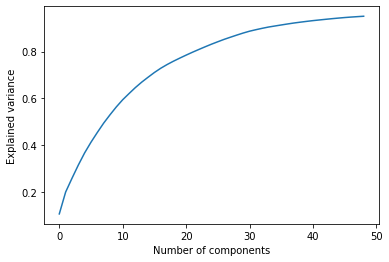

In [28]:
plt.plot(np.cumsum(pca.explained_variance_ratio_ ))
plt.xlabel ('Number of components')
plt.ylabel ('Explained variance')

## SageMaker Training and Inference in Sections Below

---
### Roles and Buckets

> To create a model, you'll first need to specify an IAM role, and to save the model attributes, you'll need to store them in an S3 bucket.

The `get_execution_role` function retrieves the IAM role you created at the time you created your notebook instance. Roles are essentially used to manage permissions and you can read more about that [in this documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html). For now, know that we have a FullAccess notebook, which allowed us to access and download the census data stored in S3.

You must specify a bucket name for an S3 bucket in your account where you want SageMaker model parameters to be stored. Note that the bucket must be in the same region as this notebook. You can get a default S3 bucket, which automatically creates a bucket for you and in your region, by storing the current SageMaker session and calling `session.default_bucket()`.

In [29]:
# We need to role so we can make API call to the SageMaker services
from sagemaker import get_execution_role

session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = get_execution_role()
print(role)

arn:aws:iam::050431322405:role/service-role/AmazonSageMaker-ExecutionRole-20220502T134169


---
## Let's define a PCA Model

To create a PCA model, we'll use the **built-in SageMaker resource**. A SageMaker estimator requires a number of parameters to be specified; these define the type of training instance to use and the model hyperparameters. A PCA model requires the following constructor arguments:

* role: The IAM role, which was specified, above.
* train_instance_count: The number of training instances (typically, 1).
* train_instance_type: The type of SageMaker instance for training.
* num_components: An integer that defines the number of PCA components to produce.
* sagemaker_session: The session used to train on SageMaker.

Documentation on the PCA model can be found [here](http://sagemaker.readthedocs.io/en/latest/pca.html).

Let's specify where to save the model training data, using prefix and the `output_path`.

In [30]:
# define location to store model artifacts
model_prefix = 'caa-customers-seg'

output_path='s3://{}/{}/'.format(bucket_name, model_prefix)

print('Training artifacts will be uploaded to: {}'.format(output_path))

Training artifacts will be uploaded to: s3://esti-sm-demo-rk/caa-customers-seg/


In [31]:
# define a PCA model
from sagemaker import PCA

# this is current features - 1
# you'll select only a portion of these to use, later
N_COMPONENTS=40

pca_SM = PCA(role=role,
             instance_count=1,
             instance_type='ml.c4.xlarge',
             output_path=output_path, # specified, above
             num_components=N_COMPONENTS, 
             sagemaker_session=session)


### Convert data into a RecordSet format

Next, prepare the data for a built-in model by converting the DataFrame to a numpy array of float values.

The *record_set* function in the SageMaker PCA model converts a numpy array into a **RecordSet** format that is the required format for the training input data. This is a requirement for _all_ of SageMaker's built-in models. The use of this data type is one of the reasons that allows training of models within Amazon SageMaker to perform faster, especially for large datasets.

In [32]:
# convert df to np array
# reduce the size of the data since I am getting size issue ---
# reduced_train_data = customer_scaled.sample(frac=0.1) # Get 50% of the data
#len(reduced_train_data) 
reduced_train_data = customer_scaled

train_data_np = customer_scaled.values.astype('float32')
reduced_train_data_np = reduced_train_data.values.astype('float32')

len(reduced_train_data) 
#reduced_train_data
# convert to RecordSet format
#formatted_train_data = pca_SM.record_set(train_data_np)
formatted_train_data = pca_SM.record_set(reduced_train_data_np)

---
## Train the model

Call the fit function on the PCA model, passing in our formatted, training data. This spins up a training instance to perform the training job.

Note that it takes the longest to launch the specified training instance; the fitting itself doesn't take much time.



In [33]:
%%time
# train the PCA mode on the formatted data
# can take up to 9 min
pca_SM.fit(formatted_train_data)


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-05-02 19:58:18 Starting - Starting the training job...
2022-05-02 19:58:45 Starting - Preparing the instances for trainingProfilerReport-1651521498: InProgress
.........
2022-05-02 20:00:12 Downloading - Downloading input data...
2022-05-02 20:00:32 Training - Downloading the training image.....Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/02/2022 20:01:33 INFO 139922473154368 integration.py:636] worker started
[05/02/2022 20:01:33 INFO 139922473154368] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[05/02/2022 20:01:33 INFO 139922473154368] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {'feature_dim': '326', 'mini

---
## Accessing the PCA Model Attributes

After the model is trained, we can access the underlying model parameters.

### Unzip the Model Details

Now that the training job is complete, you can find the job under **Jobs** in the **Training**  subsection  in the Amazon SageMaker console. You can find the job name listed in the training jobs. Use that job name in the following code to specify which model to examine.

Model artifacts are stored in S3 as a TAR file; a compressed file in the output path we specified + 'output/model.tar.gz'. The artifacts stored here can be used to deploy a trained model.

In [35]:
# Get the name of the training job, you need to copy-paste

# from time import gmtime, strftime
# output_time = strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# output_folder = 'kmeans-' + output_time

# Note: copy training_job from SageMaker console - Training - Training Job or else you'll get an error
# Need to fix this later
training_job_name = pca_SM.latest_training_job.job_name

# where the model is saved, by default
model_key = os.path.join(model_prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

caa-customers-seg/pca-2022-05-02-19-58-18-756/output/model.tar.gz


2304

### MXNet Array

Many of the Amazon SageMaker algorithms use MXNet for computational speed, including PCA, and so the model artifacts are stored as an array. After the model is unzipped and decompressed, we can load the array using MXNet.

You can take a look at the MXNet [documentation, here](https://aws.amazon.com/mxnet/).

In [37]:
import mxnet as mx

# loading the unzipped artifacts
pca_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(pca_model_params)

{'s': 
[16.124136 16.52358  17.655766 18.12279  18.286295 18.422806 20.461885
 21.336954 22.123997 24.487906 25.773563 26.307755 26.591352 27.917677
 28.269022 29.22206  29.651596 29.994473 30.707602 31.254147 31.776722
 33.059696 34.747944 37.238895 39.369156 40.024483 42.101868 44.302334
 44.904686 48.28287  50.80143  52.204845 55.225758 56.48065  58.990906
 63.20496  65.80269  67.01726  84.50199  90.279785]
<NDArray 40 @cpu(0)>, 'v': 
[[-0.00031207 -0.00568408  0.00152706 ...  0.18228847 -0.00111665
   0.00509285]
 [-0.00618004 -0.05020567  0.01372331 ...  0.03060548 -0.00195808
   0.00072446]
 [-0.02844065  0.00374719  0.04218556 ... -0.0130204   0.09644474
  -0.03190135]
 ...
 [-0.01915166  0.03283451  0.00301005 ... -0.01799604  0.00223555
  -0.00050097]
 [ 0.03682139  0.10483966 -0.04209843 ... -0.03685244 -0.00337039
  -0.00116878]
 [ 0.05418318  0.01238547  0.02960724 ... -0.0220144  -0.00246071
  -0.00119931]]
<NDArray 326x40 @cpu(0)>, 'mean': 
[[5.00000000e-01 2.35513240e-01

---
## PCA Model Attributes

Three types of model attributes are contained within the PCA model.

* **mean**: The mean that was subtracted from a component in order to center it.
* **v**: The makeup of the principal components; (same as ‘components_’ in an sklearn PCA model).
* **s**: The singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.
    
We are only interested in v and s. 

From s, we can get an approximation of the data variance that is covered in the first `n` principal components. The approximate explained variance is given by the formula: the sum of squared s values for all top n components over the sum over squared s values for _all_ components:

\begin{equation*}
\frac{\sum_{n}^{ } s_n^2}{\sum s^2}
\end{equation*}

From v, we can learn more about the combinations of original features that make up each principal component.


In [38]:
import pandas as pd
# get selected params
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

## Data Variance

Our current PCA model creates 40 principal components, but when we create new dimensionality-reduced training data, we'll only select a few, top n components to use. To decide how many top components to include, it's helpful to look at how much **data variance** the components capture. For our original, high-dimensional data, 48 features captured 95%+ of our data variance. If we discard some of these higher dimensions, we will lower the amount of variance we can capture.

### Tradeoff: dimensionality vs. data variance

As an illustrative example, say we have original data in three dimensions. So, three dimensions capture 100% of our data variance; these dimensions cover the entire spread of our data. The below images are taken from the PhD thesis,  [“Approaches to analyse and interpret biological profile data”](https://publishup.uni-potsdam.de/opus4-ubp/frontdoor/index/index/docId/696) by Matthias Scholz, (2006, University of Potsdam, Germany).

<img src='nbimg/pca-image-1.png' width=35% />

Now, you may also note that most of this data seems related; it falls close to a 2D plane, and just by looking at the spread of the data, we  can visualize that the original, three dimensions have some correlation. So, we can instead choose to create two new dimensions, made up of linear combinations of the original, three dimensions. These dimensions are represented by the two axes/lines, centered in the data. 

<img src='nbimg/pca-image-2.png' width=70% />

If we project this in a new, 2D space, we can see that we still capture most of the original data variance using *just* two dimensions. There is a tradeoff between the amount of variance we can capture and the number of component-dimensions we use to represent our data.

When we select the top n components to use in a new data model, we'll typically want to include enough components to capture about 80-90% of the original data variance. In this project, we are looking at generalizing over a lot of data and we'll aim for about 80% coverage.

**Note**: The _top_ principal components, with the largest s values, are actually at the end of the s DataFrame. Let's print out the s values for the top n, principal components.

In [39]:
# Need to try - looking at top 5 components
n_principal_components = 5

start_idx = N_COMPONENTS - n_principal_components  # 40-n

# print a selection of s
print(s.iloc[start_idx:, :])

            0
35  63.204960
36  65.802689
37  67.017258
38  84.501991
39  90.279785


### Now let's  Calculate the explained variance

In creating new training data, you'll want to choose the top n principal components that account for at least 80% data variance. 

Complete a function, `explained_variance` that takes in the entire array `s` and a number of top principal components to consider. Then return the approximate, explained variance for those top n components. 

For example, to calculate the explained variance for the top 5 components, calculate s squared for *each* of the top 5 components, add those up and normalize by the sum of *all* squared s values, according to this formula:

\begin{equation*}
\frac{\sum_{5}^{ } s_n^2}{\sum s^2}
\end{equation*}

> Using this function, you should be able to answer the **question**: What is the smallest number of principal components that captures at least 80% of the total variance in the dataset?

In [40]:
# Calculate the explained variance for the top n principal components
# you may assume you have access to the global var N_COMPONENTS
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    # your code here
    
    start_idx = len(s) - n_top_components  # 40-n

    # print a selection of s
    s_sq_topn_sum = np.sum(np.square(s.iloc[start_idx:, :].values))
    s_sq_sum = s_sq_topn_sum + np.sum(np.square(s.iloc[:start_idx, :].values))
    return s_sq_topn_sum / s_sq_sum


### Test Cell

Test out your own code by seeing how it responds to different inputs; does it return a reasonable value for the single, top component? What about for the top 5 components?

In [41]:
import numpy as np
# test cell - 5
n_top_components = 5 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.39548874


As an example, you should see that the top 5 principal components accounts for about 40% of our data variance! Next, you may be wondering what makes up this (and other components); what linear combination of features make these components so influential in describing the spread of our data?

Below, let's take a look at our original features and use that as a reference.

In [42]:
# features
#features_list = customer_scaled.columns.values
#print('Features: \n', features_list)

## Component Makeup

We can now examine the makeup of each PCA component based on **the weightings of the original features that are included in the component**. The following code shows the feature-level makeup of the first component.

Note that the components are again ordered from smallest to largest and so I am getting the correct rows by calling N_COMPONENTS-1 to get the top, 1, component.

In [43]:
!pip install seaborn

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [44]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    ## Function displays component make up of features based on number of features selected by n_weights 
    
#     print(v)
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    
    v_1 = np.squeeze(v_1_row.values)
    
    # match weights to features in customer_scaled dataframe, using list comprehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()


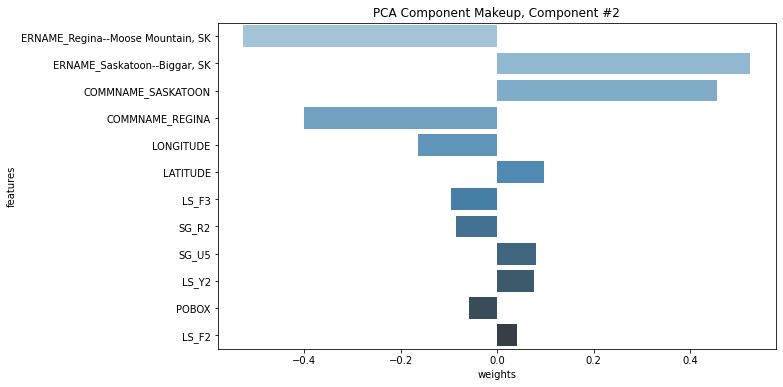

In [45]:
# display makeup of second component
num=2
display_component(v, customer_scaled.columns.values, component_num=num, n_weights=12) # nweights=12 shows 12 features below

---
# Deploying the PCA Model

We can now deploy this model and use it to make "predictions". Instead of seeing what happens with some test data, we'll actually want to pass our training data into the deployed endpoint to create principal components for each data point. 

Run the cell below to deploy/host this model on an instance_type that we specify.

In [46]:
pca_SM=sagemaker.estimator.Estimator.attach(training_job_name=pca_SM.latest_training_job.name, sagemaker_session=None)


2022-05-02 20:03:13 Starting - Preparing the instances for training
2022-05-02 20:03:13 Downloading - Downloading input data
2022-05-02 20:03:13 Training - Training image download completed. Training in progress.
2022-05-02 20:03:13 Uploading - Uploading generated training model
2022-05-02 20:03:13 Completed - Training job completed


In [47]:
%%time
# this takes a little while, around 7mins
pca_predictor = pca_SM.deploy(initial_instance_count=2, 
                              instance_type='ml.c4.4xlarge')

---------!CPU times: user 150 ms, sys: 22.5 ms, total: 172 ms
Wall time: 4min 32s


We can pass the original, numpy dataset to the model and transform the data using the model we created. Then we can take the largest n components to reduce the dimensionality of our data.

In [48]:
pca_predictor=sagemaker.PCAPredictor(endpoint_name=pca_predictor.endpoint_name)

In [49]:
# from sagemaker.serializers import NumpySerializer
# from sagemaker.deserializers import NumpyDeserializer
# pca_predictor.serializer = NumpySerializer()
# pca_predictor.deserializer = NumpyDeserializer()

reduced_train_data_2 = customer_scaled.sample(frac=0.2)
reduced_train_data_pred = reduced_train_data_2.values.astype('float32')



In [50]:
print(pca_predictor.content_type)
print(pca_predictor.accept)

application/x-recordio-protobuf
('application/x-recordio-protobuf',)


In [51]:
print("done")

done


In [52]:
# pass np train data to the PCA model reduced_train_data_np
import json
train_pca = pca_predictor.predict(reduced_train_data_pred)

In [53]:
# check out the first item in the produced training features
data_idx = 0
print(train_pca[data_idx])

label {
  key: "projection"
  value {
    float32_tensor {
      values: -0.10783682763576508
      values: -0.1753077208995819
      values: -0.0898422971367836
      values: 0.09873241186141968
      values: -0.01132124662399292
      values: -0.03368663787841797
      values: -0.04170083999633789
      values: -0.015291161835193634
      values: 0.029626984149217606
      values: -0.06748785078525543
      values: -0.0687500536441803
      values: -0.11307545006275177
      values: 0.1023564338684082
      values: 0.13359999656677246
      values: -0.02081000804901123
      values: 0.4195825457572937
      values: 0.0732751339673996
      values: -0.08104562014341354
      values: 0.38063693046569824
      values: -0.05540338531136513
      values: 0.3242374658584595
      values: 0.007301792502403259
      values: -0.10280997306108475
      values: -0.09421072900295258
      values: -0.4346792995929718
      values: -0.37418538331985474
      values: 0.6484639644622803
      values

In [54]:
len(train_pca)

2778

### Batch Predictions

In [55]:
folder=f'{prefix}/batch'
train_s3=f's3://{bucket_name}/{folder}/transform_input.csv'
pca_transformer = pca_SM.transformer(
    instance_count=1,
    instance_type="ml.m4.xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path="s3://{}/{}/pca/transformed".format(bucket_name, folder),
)
pca_transformer.transform(train_s3, content_type="text/csv", split_type="Line")
pca_transformer.wait()

.....................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[05/02/2022 20:21:58 INFO 139825906640704] loaded entry point class algorithm.serve.server_config:config_api
[05/02/2022 20:21:58 INFO 139825906640704] nvidia-smi: took 0.031 seconds to run.
[05/02/2022 20:21:58 INFO 139825906640704] nvidia-smi identified 0 GPUs.
[05/02/2022 20:21:58 INFO 139825906640704] loading entry points
[05/02/2022 20:21:58 INFO 139825906640704] Loaded iterator creator application/x-labeled-vector-protobuf for content type ('application/x-labeled-vector-protobuf', '1.0')
[05/02/2022 20:21:58 INFO 139825906640704] Loaded iterator creator application/x-recordio-protobuf for content type ('application/x-recordio-protobuf', '1.0')
[05/02/2022 20:21:58 INFO 139825906640704] Loaded iterator creator protobuf for content type ('protobuf', '1.0')
[05/02/2022 20:21:58 INFO 139825906640704] loaded request iterator application/json
Docker ent

In [56]:
!aws s3 cp --recursive $pca_transformer.output_path ./

download: s3://esti-sm-demo-rk/caa/batch/pca/transformed/transform_input.csv.out to ./transform_input.csv.out


In [57]:
import json
with open('transform_input.csv.out') as f:
    train_pca_batch=[json.loads(x) for x in f.readlines()]

In [58]:
train_pca_batch[0]

{'projection': [0.058930981904268,
  0.314813941717147,
  0.026734799146652,
  -0.356682389974594,
  0.13173758983612,
  0.081881880760192,
  -0.029709950089454,
  0.042412631213665,
  0.060818023979663,
  -0.015885412693023,
  -0.098773166537284,
  -0.14441293478012,
  -0.298982709646225,
  -0.015863835811614,
  0.375711858272552,
  -0.076651960611343,
  0.232430547475814,
  -0.472367882728576,
  -0.574166893959045,
  -0.393378436565399,
  0.433525383472442,
  0.285595059394836,
  -0.172194257378578,
  0.034993648529052,
  1.087530136108398,
  -0.024444162845611,
  -0.141823068261146,
  0.554919481277465,
  -0.776657938957214,
  -0.048097699880599,
  -0.277821272611618,
  0.091885946691036,
  0.241086453199386,
  0.672033011913299,
  0.575162529945373,
  -0.646336197853088,
  -0.27695620059967,
  0.084701538085937,
  -0.918903350830078,
  0.82382583618164]}

### Step : Create a transformed DataFrame

For each of our data points, get the top n component values from the list of component data points, returned by our predictor above, and put those into a new DataFrame.


In [59]:
# create dimensionality-reduced data
def create_transformed_df(train_pca, data_scaled, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param data_scaled: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by State-County, with n_top_component values as columns.        
     '''
    # create a dataframe of component features, 
    # create new dataframe to add data to
    transformed_df = pd.DataFrame()
    
    # for each of our new, transformed data points
    # append the component values to the dataframe
    for data in train_pca:
        # get component values for each data point
        components = data.label['projection'].float32_tensor.values
        transformed_df = transformed_df.append([list(components)])
    
    transformed_df.index = data_scaled.index
    
    # keep only the top n components
    start_idx = N_COMPONENTS - n_top_components
    transformed_df = transformed_df.iloc[:,start_idx:]
    
    # reverse columns, component order
    return transformed_df.iloc[:, ::-1]


Now we can create a dataset where each customer is described by the top n principle components that we analyzed earlier. Each of these components is a linear combination of the original feature space. We can interpret each of these components by analyzing the makeup of the component, shown previously.

### Define the `top_n` components to use in this transformed data

Your code should return data and with as many columns as `top_n` components.

You can also choose to add descriptive column names for this data; names that correspond to the component number or feature-level makeup.

In [60]:
## Specify top n
top_n = 10

# call your function and create a new dataframe reduced_train_data
#ustomers_transformed = create_transformed_df(train_pca, customer_scaled, n_top_components=top_n)
customers_transformed = create_transformed_df(train_pca, reduced_train_data_2, n_top_components=top_n)

## TODO: Add descriptive column names
pca_cols = ['c_1','c_2','c_3','c_4','c_5','c_6','c_7','c_8','c_9','c_10']
customers_transformed.columns = pca_cols

# print result
#customers_transformed.head()
customers_transformed

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10
11235,-0.560959,0.125972,0.133270,-0.283193,0.770289,0.545223,0.772276,0.291723,0.544894,-0.712874
176,0.529364,1.019682,-0.816966,-0.049720,-0.594019,-0.755622,0.649897,-0.048670,0.399112,0.888831
4185,0.782251,-0.978071,0.407965,0.594037,0.183014,-0.470437,-0.039738,0.019753,0.546726,-0.661794
5161,0.742347,-0.879314,-0.620510,-0.301158,0.248062,-0.482766,0.628446,0.159329,0.435481,-0.886327
13583,0.835407,-0.899495,0.391060,-0.298418,-0.623410,0.526796,0.790402,0.142182,0.488273,0.753455
...,...,...,...,...,...,...,...,...,...,...
9819,0.508581,1.135181,0.198406,-0.002598,0.020724,0.511145,0.660480,0.201790,0.080048,0.049019
3102,0.584321,0.983347,0.370481,1.042956,0.037980,-0.477922,-0.070965,0.003365,0.578908,-0.631159
12624,-1.294865,-0.175446,0.420653,-0.156768,-0.615058,0.548920,-0.146291,-0.745405,-0.434156,-0.003031
3860,1.041175,-0.698020,0.349087,-0.777972,0.062290,0.715361,-0.406032,-0.755065,-0.452137,-0.118784


In [62]:
customers_transformed.to_csv(f"s3://{bucket_name}/{folder}/km_batch_input.csv", header=False)

### Delete the Endpoint!

Now that we've deployed the mode and created our new, transformed training data, we no longer need the PCA endpoint.

As a clean up step, you should always delete your endpoints after you are done using them (and if you do not plan to deploy them to a website, for example).

In [63]:
# delete predictor endpoint - cost management
session.delete_endpoint(pca_predictor.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


---
# Customer Segmentation 

Now, you’ll use the unsupervised clustering algorithm, k-means, to segment Customers using their PCA attributes, which are in the transformed DataFrame we just created. K-means is a clustering algorithm that identifies clusters of similar data points based on their component makeup. Since we have lots of customers and 326 attributes in the original dataset, the large feature space may have made it difficult to cluster the customers effectively. Instead, we have reduced the feature space to 10 PCA components, and we’ll cluster on this transformed dataset.

### Define a k-means model

Your task will be to instantiate a k-means model. A `KMeans` estimator requires a number of parameters to be instantiated, which allow us to specify the type of training instance to use, and the model hyperparameters. 

You can read about the required parameters, in the [`KMeans` documentation](https://sagemaker.readthedocs.io/en/stable/kmeans.html); note that not all of the possible parameters are required.


### Choosing a "Good" K

One method for choosing a "good" k, is to choose based on empirical data. A bad k would be one so *high* that only one or two very close data points are near it, and another bad k would be one so *low* that data points are really far away from the centers.

You want to select a k such that data points in a single cluster are close together but that there are enough clusters to effectively separate the data. You can approximate this separation by measuring how close your data points are to each cluster center; the average centroid distance between cluster points and a centroid. After trying several values for k, the centroid distance typically reaches some "elbow"; it stops decreasing at a sharp rate and this indicates a good value of k. 

In [64]:
# define a KMeans estimator
# select cluster to 8
from sagemaker import KMeans

NUM_CLUSTERS = 5

km = KMeans(role=role,
            train_instance_count=1,
            train_instance_type='ml.c4.xlarge',
            output_path=output_path, # specified, above
            k=NUM_CLUSTERS,
            sagemaker_session=session)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Step : Create formatted, k-means training data

Just as before, you should convert the `customers_transformed` df into a numpy array and then into a RecordSet. This is the required format for passing training data into a `KMeans` model.

In [65]:
# convert the transformed dataframe into record_set data
customers_transformed_np = customers_transformed.values.astype('float32')

# convert to RecordSet format
formatted_train_data = km.record_set(customers_transformed_np)

---
## Train the k-means model

Pass in the formatted training data and train the k-means model.

note: Check out the profiler-report.ipynb under kmean-job folder

In [66]:
%%time
# train kmeans - this takes around 4 min
km.fit(formatted_train_data)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2022-05-02 20:24:18 Starting - Starting the training job...ProfilerReport-1651523058: InProgress
...
2022-05-02 20:25:03 Starting - Preparing the instances for training...............
2022-05-02 20:27:46 Downloading - Downloading input data
2022-05-02 20:27:46 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/02/2022 20:27:50 INFO 140607784367936] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore': 'auto', '_log_level': 'info', 

---
### Synchronous Inference: Deploy the k-means model for real-time inference

Deploy the trained model to create a `kmeans_predictor`

In [67]:
%%time
# deploy the model to create a predictor ml.c4.xlarge
kmeans_predictor = km.deploy(initial_instance_count=1,
                             instance_type='ml.t2.medium')

#if running from a disconnected notebook
# kmeans_predictor=sagemaker.KmeansPredictor(endpoint_name="<your-endpoint-name>")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


----------!CPU times: user 198 ms, sys: 24.1 ms, total: 222 ms
Wall time: 5min 2s


In [68]:
kmeans_predictor

###  Pass in the training data and assign predicted cluster labels

After deploying the model, you can pass in the k-means training data, as a numpy array, and get resultant, predicted cluster labels for each data point.

In [69]:
# get the predicted clusters for all the kmeans training data reduced_train_data_np

cluster_info = kmeans_predictor.predict(customers_transformed_np)

---
### Batch Inference - Amazon SageMaker Batch Transform


Use Batch Transform when you need prediction for an entire dataset - one after another

For this, we need to specify:
- Hardware specification (instance count and type).  Prediction is embarassingly parallel, so feel free to test this with multiple instances, but since our dataset is not enormous, we'll stick to one.
- `strategy`: Which determines how records should be batched into each prediction request within the batch transform job.  'MultiRecord' may be faster, but some use cases may require 'SingleRecord'.
- `output_path`: The S3 location for batch transform to be output.  Note, file(s) will be named with '.out' suffixed to the input file(s) names.  In our case this will be 'train.csv.out'.  Note that in this case, multiple batch transform runs will overwrite existing values unless this is updated appropriately.


In [70]:
'''
In the previous example we used the model variable to access the transformed, here we will explictly specify model
and inference to simulate a situation where model training and inference will be done in separate notebooks or at 
separate times.
'''
km_model = session.create_model_from_job(
    km._current_job_name, name="{}-test".format(km._current_job_name)
)

In [71]:

from sagemaker.transformer import Transformer

job_name=km.latest_training_job.name
output_path = f"s3://{bucket_name}/{folder}/kmeans_batch_output/"
train_s3=f"s3://{bucket_name}/{folder}/km_batch_input.csv"
transformer = Transformer(km_model,
   instance_count=1,
   instance_type='ml.m4.xlarge',
   strategy="MultiRecord",
   max_payload=6,
   max_concurrent_transforms=1,
   output_path=output_path,
   assemble_with="Line", accept="text/csv",
   sagemaker_session=session
)

transformer.transform(train_s3, input_filter="$[1:]",content_type="text/csv", split_type="Line", join_source="Input")
transformer.wait()

......................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
[05/02/2022 20:39:39 INFO 140020492883776] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
[05/02/2022 20:39:42 WARNING 140020492883776] Loggers have already been setup.
[05/02/2022 20:39:42 INFO 140020492883776] loading entry points
[05/02/2022 20:39:42 INFO 140020492883776] Loaded iterator creator application/x-recordio-protobuf for content type ('application/x-recordio-protobuf', '1.0')
[05/02/2022 20:39:42 INFO 140020492883776] loaded request iterator application/json
[05/02/2022 20:39:42 INFO 140020492883776] loaded request iterator application/jsonlines
[05/02/2022 20:39:42 INFO 140020492883776] loaded request iterator application/x-recordio-protobuf
[05/02/2022 20:39:42 INFO 140020492883776] loaded request iterator text/csv
[05/02/2022 20:39:42 INFO 140020492883776] loaded response encoder application/json
[05/02/2022

In [72]:
!aws s3 cp --recursive $transformer.output_path ./

download: s3://esti-sm-demo-rk/caa/batch/kmeans_batch_output/km_batch_input.csv.out to ./km_batch_input.csv.out


In [73]:
km_df_batch=pd.read_csv('km_batch_input.csv.out')

In [74]:
km_df_batch.columns=['index','c_1','c_2','c_3','c_4','c_5','c_6','c_7','c_8','c_9','c_10', 'cluster_label','centroid_distance']

In [75]:
km_df_batch.head()

,index,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,cluster_label,centroid_distance
0,176,0.529364,1.019682,-0.816966,-0.049720,-0.594019,-0.755622,0.649897,-0.048670,0.399112,0.888831,2.0,1.646390
1,4185,0.782251,-0.978071,0.407965,0.594037,0.183014,-0.470437,-0.039738,0.019753,0.546726,-0.661794,4.0,1.289016
2,5161,0.742347,-0.879314,-0.620510,-0.301158,0.248062,-0.482766,0.628446,0.159329,0.435481,-0.886327,4.0,1.454180
3,13583,0.835407,-0.899495,0.391060,-0.298418,-0.623410,0.526796,0.790402,0.142182,0.488273,0.753455,4.0,1.463206
4,6758,0.821163,-0.975021,0.412260,0.738008,0.229104,-0.453756,-0.067199,0.017357,0.554004,-0.682565,4.0,1.386560


---
## Exploring the resultant clusters

The resulting predictions should give you information about the cluster that each data point belongs to.

You should be able to answer the **question**: which cluster does a given data point belong to?

In [76]:
# print cluster info for first data point
data_idx = 0

print('customer is: ', customers_transformed.index[data_idx])
print()
print(cluster_info[data_idx])

customer is:  11235

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 3.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 1.1361920833587646
    }
  }
}



### Visualize the distribution of data over clusters

Get the cluster labels for each of our data points (customers segment) and visualize the distribution of points over each cluster.

In [77]:
# get all cluster labels
cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in cluster_info]

In [78]:
label_series=pd.Series([x for x in cluster_labels])

In [79]:
customers_transformed['cluster_label']=label_series.values

In [80]:
final_df=customers_transformed.reset_index()

In [ ]:
#let's connect index back to original dataframe

In [ ]:
final_df.head()

In [ ]:
final_df=final_df.merge(customer_df, how='inner', left_on='index', right_on='customer_no')

In [ ]:
final_df.drop(columns=['c_1','c_2','c_3','c_4','c_5','c_6','c_7','c_8','c_9','c_10'], inplace=True)

In [ ]:
final_df.head()

In [ ]:
# count up the points in each cluster
cluster_df = pd.DataFrame(cluster_labels)
print(cluster_df.head())

In [ ]:
len(cluster_df)

Now, you may be wondering, what do each of these clusters tell us about these data points? To improve explainability, we need to access the underlying model to get the cluster centers. These centers will help describe which features characterize each cluster.

In [ ]:
# another method of visualizing the distribution
# display a histogram of cluster counts
ax =plt.subplots(figsize=(6,3))
ax = plt.hist(cluster_labels, bins=5,  range=(-0.5, 4.5), color='blue', rwidth=0.5)

title="Histogram of Cluster Counts"
plt.title(title, fontsize=12)
plt.show()

### Delete the Endpoint!

Now that you've deployed the k-means model and extracted the cluster labels for each data point, you no longer need the k-means endpoint.

In [ ]:
# delete kmeans endpoint
session.delete_endpoint(kmeans_predictor.endpoint)

---
# Model Attributes & Explainability

Explaining the result of the modeling is an important step in making use of our analysis. By combining PCA and k-means, and the information contained in the model attributes within a SageMaker trained model, you can learn about a population and remark on some patterns you've found, based on the data.

###  Access the k-means model attributes

Extract the k-means model attributes from where they are saved as a TAR file in an S3 bucket.

You'll need to access the model by the k-means training job name, and then unzip the file into `model_algo-1`. Then you can load that file using MXNet, as before.

In [ ]:
# download and unzip the kmeans model file
# use the name model_algo-1

# Note go to the SageMaker console - Trainings - Training jobs - kmeans-xxx
# Need to fix this, too
kmeans_job_name = km.latest_training_job.name

model_key = os.path.join(prefix, kmeans_job_name, 'output/model.tar.gz')

# download the model file
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

In [ ]:
# get the trained kmeans params using mxnet
kmeans_model_params = mx.ndarray.load('model_algo-1')

print(kmeans_model_params)

There is only 1 set of model parameters contained within the k-means model: the cluster centroid locations in PCA-transformed, component space.

* **centroids**: The location of the centers of each cluster in component space, identified by the k-means algorithm. 


In [ ]:
# get all the centroids
cluster_centroids=pd.DataFrame(kmeans_model_params[0].asnumpy())
cluster_centroids.columns=customers_transformed.columns[:-1]

display(cluster_centroids)

### Visualizing Centroids in Component Space

You can't visualize 7-dimensional centroids in space, but you can plot a heatmap of the centroids and their location in the transformed feature space. 

This gives you insight into what characteristics define each cluster. Often with unsupervised learning, results are hard to interpret. This is one way to make use of the results of PCA + clustering techniques, together. Since you were able to examine the makeup of each PCA component, you can understand what each centroid represents in terms of the PCA components.

In [ ]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (12,9))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

If you've forgotten what each component corresponds to at an original-feature-level, that's okay! You can use the previously defined `display_component` function to see the feature-level makeup.

In [ ]:
# what do each of these components mean again?
# let's use the display function, from above
component_num=1
display_component(v, customer_scaled.columns.values, component_num=component_num)

## Final Cleanup!

* Double check that you have deleted all your endpoints.
* I'd also suggest manually deleting your S3 bucket, models, and endpoint configurations directly from your AWS console.

You can find thorough cleanup instructions, [in the documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-cleanup.html).

---
# Conclusion

You have just walked through a machine learning workflow for unsupervised learning, specifically, for clustering a dataset using k-means after reducing the dimensionality using PCA. By accessing the underlying models created within  SageMaker, you were able to improve the explainability of your model and draw insights from the resultant clusters. 

Using these techniques, you have been able to better understand the essential characteristics of different customers in Saskatchewan and segment them into similar groups, accordingly.